In [2]:
import json 
import numpy as np
import sys

## merge museum metadata

In [8]:
# read file
def read_file(file_name:str)->list[dict]:
    '''
    read the file 
    
    args:
        file_name:str, json format
    '''
    
    data =[]
    with open(file_name,'rt') as f:
        for line in f:
            data.append(json.loads(line))
    
    return data

### wikipedia

In [ ]:
# wiki_filename_olist = './data_1101/wikipedia_museum_list.jsonl'
# wiki_filename_alist = './data_1101/wikipedia_added_list.jsonl'
# wiki_lists = read_file(wiki_filename_olist)
# wiki_lists.extend(read_file(wiki_filename_alist))

# with open('wikipedia_museum_list_merged.jsonl','wt') as f:
#     for museum in wiki_lists:
#         f.write(json.dumps(museum)+'\n')

In [9]:
wiki_filename_list = './data_1101/wikipedia_museum_list_merged.jsonl'
wiki_filename_articles = './data_1101/wikipedia_museum_articles3.jsnol'
wmuseum_filename = './data_1101/which_museum_museum_info.jsonl'

In [10]:
#read file 
wiki_list = read_file(wiki_filename_list)
wiki_articles = read_file(wiki_filename_articles)

In [17]:
# reconstruct list dictionary

# museum_ids = [museum['museum_id'] for museum in wiki_articles]
# wikipedia_museum_lists_merged =[]
# for museum in wiki_lists:
#     if museum['museum_id'] in museum_ids:
#         wikipedia_museum_lists_merged.append(museum)
# with open('wikipedia_museum_list_merge.jsonl','wt') as f:
#     for museum in wikipedia_museum_lists_merged:
#         f.write(json.dumps(museum)+'\n')

In [367]:
# keysset =set()

# for museum in wiki_list:
#     keys ='/'.join(list(museum.keys())[2:])
#     keysset.add(keys)
# with open('keyset.csv','wt') as f:
#     for key in keysset:
#         f.write(key+'\n')

# keysset

In [54]:
# with open('keyset.csv','wt') as f:
#     for line in keysset:
#         f.write(line+'\n')

In [12]:
def reconstruct_wiki_list(museum:dict[str,str])->dict[str,dict]:
    ''' 
    reconstruct wiki list to set the museum as key
    
    args:
        museum:dict[str,str], directly from wiki_list
    '''
    
    new_museum = {}
    for key,value in museum.items():
        key = key.lower()
        if 'name' in key:
            name = value[1]  #use url as key, since some museums share the same name but are actually different
        if key in ['museum_state']:
            new_museum[key] = value
        elif 'image' in key:
            new_museum['museum_wiki_image'] = value[1]
        elif key in ['type','subject','area of study']:
            new_museum['category'] = value[0]
        elif key in ['notes','summary']:
            new_museum['museum_wiki_decription'] = value[0]
        else:
            pass
        
    return {name:new_museum}

In [13]:
new_wiki_list ={}
for idx,museum in enumerate(wiki_list):
    new_wiki_list.update(reconstruct_wiki_list(museum))


In [15]:
list_names = list(new_wiki_list.keys())

In [15]:
def reconstruct_wiki_article(museum:dict)->dict:
    new_museum ={}
    others = {}
    
    for key,value in museum.items():
        key = key.lower()

        if key in ['museum_name','museum_url','img_url','coordinates','location','website','type']:
            new_museum[key] = value
        elif 'article' in key:
            new_museum['wiki_article'] = value
        elif ('nrhp' in key) or (key in ['museum_id']):
            pass
        else:
            others[key] = value
        
    new_museum['other'] = others

    return new_museum
    

In [16]:
new_wiki_articles = []

for idx,museum in enumerate(wiki_articles):
    single_museum = {'museum_id':idx}
    single_museum.update(reconstruct_wiki_article(museum))
    new_wiki_articles.append(single_museum)
    

In [19]:
museum_wiki_metadata =[]

for museum in new_wiki_articles:
    try:
        museum.update(new_wiki_list[museum['museum_url']])
    except KeyError:
        print(museum)
    
    img_url = []
    try:
        url1 = museum.pop('img_url')
        if len(url1)>0:
            img_url.append(url1)
    except:
        pass
    
    try:
        url2 = museum.pop('museum_wiki_image')
        if len(url2)>0:
            img_url.append(url2)
    except:
        pass
    
    museum['img_urls'] = img_url
    
    museum_wiki_metadata.append(museum)
        

In [21]:
with open('./data_1101/museum_wiki_metadata.jsonl','wt') as f:
    for museum in museum_wiki_metadata:
        f.write(json.dumps(museum)+'\n')

### which museum 

In [22]:
wmuseum_data = read_file(wmuseum_filename)
wiki_museums_names = {museum['museum_name']:idx for idx,museum in enumerate(museum_wiki_metadata)}

museum_metadata = []


num = 0
wmuseum_data2 = {}
for museum in wmuseum_data:
    new_museum = {}
    for key,value in museum.items():
        if key in ['Opening hours ', 'Admission ']:
            for idx,ele in enumerate(museum[key]):
                if type(museum[key]) == str:
                    museum[key] = museum[key].strip()
                elif type(museum[key]) == list:
                    museum[key][idx][1] = museum[key][idx][1].strip()
        
        if key not in ['museum_name','wmuseum_link']:
            new_museum[key.strip().lower()]=museum[key]        
        
    if museum['museum_name'] in wiki_museums_names:
       wmuseum_data2[museum['museum_name']] = new_museum
        

### data fushion

In [23]:
museum_wiki_metadata2 = []
for museum in museum_wiki_metadata:
    name = museum['museum_name'] 

    try:
        wmimg = wmuseum_data2[name].pop('image')
        museum['img_urls'] = museum['img_urls'].append(wmimg)
    except KeyError:
        pass

    try:
        museum['wm_description'] =  wmuseum_data2[name].pop('description')
    except KeyError:
        museum['wm_description'] =''

    try:
        museum.update(wmuseum_data2[name])
    except KeyError:
        pass
    
    museum_wiki_metadata2.append(museum)

In [34]:
# drop duplicates
unique_dict = {(museum['museum_name'],museum['museum_url']):museum for museum in museum_wiki_metadata2}
new_museum_wiki_metadata2 = [value for key,value in unique_dict.items()]

In [35]:
with open('./data_1101/museum_wiki_metadata3.jsonl','wt') as f:
    idx = 0
    for museum in new_museum_wiki_metadata2:
        museum['museum_id'] = idx
        f.write(json.dumps(museum)+'\n')
        idx +=1

In [93]:
museum_wiki_metadata =[]
with open('./data_1101/museum_wiki_metadata3.jsonl','rt') as f:
    for line in f:
        museum_wiki_metadata.append(json.loads(line))

museum_category = []
for museum in museum_wiki_metadata:
    try:
        # museum_category.append(museum['category'])
        museum_category.append({'museum_id':museum['museum_id'],'museum_name':museum['museum_name'],'category':museum['category']})
    except KeyError:
        # museum_category.append('others')
        museum_category.append({'museum_id':museum['museum_id'],'museum_name':museum['museum_name'],'category':'unknown'})

In [94]:
filename = 'data_1101/museum_category.jsonl'
with open(filename,'wt') as f:
    for line in museum_category:
        f.write(json.dumps(line)+'\n')

In [38]:
# from sentence_transformers import SentenceTransformer, util

# def get_new_category(cat:str,cat20_emb,model:SentenceTransformer,cat20:list[str])->str:
#         cat = cat.replace('-',' ').strip().lower()
#         new_cat = []
        
#         if cat  =='unknown':
#            return ['others']
   
#         else:
#            for cat1 in cat20:
#                 if cat1 in cat:
#                     new_cat.append(cat1)
                    
#            if len(new_cat) ==0:
#                cat_emb = model.encode(cat)
#                scores = util.dot_score(cat_emb,cat20_emb)[0].cpu().tolist()
#                scores_list = list(zip(cat20,scores))
#                scores_list = sorted(scores_list,key = lambda x:x[1],reverse = True)
#                new_cat.append('others')
#                new_cat.extend([i[0] for i in scores_list[:2]])
               
#                new_cat = list(set(new_cat))
        
#            return new_cat

/opt/anaconda3/envs/py3.12.3/lib/python3.12/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange


In [39]:
# from tqdm import tqdm

# cat20 = ['art','history','agriculture','transportation','ethnic','industry','military',\
#         'open-air','aviation','maritime','religious','sports','hall of fame','science','music','religious','multiple','others']

# model = SentenceTransformer('sentence-transformers/msmarco-MiniLM-L12-cos-v5')
# cat20_emb = model.encode(cat20)
# for idx,museum in tqdm(enumerate(museum_category),total = len(museum_category)):
# # museum = museum_category[0]
#         new_cat = get_new_category(museum['category'],cat20_emb,model,cat20)
#         museum['new_category'] = new_cat


/opt/anaconda3/envs/py3.12.3/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
100%|██████████| 5716/5716 [00:45<00:00, 125.88it/s]


In [ ]:
# # use hugging face zero-shot model to recategorize museums
# from transformers import pipeline 

#     #initialize classifier
# classifier = pipeline("zero-shot-classification",model="facebook/bart-large-mnli")

In [20]:
# from tqdm import tqdm

# cat20 = ['art','history','agriculture','transportation','ethnic','industry','military',\
#         'open-air','aviation','maritime','religious','sports','hall of fame','science','music','multiple','others']

# num = 0
# for idx,museum in tqdm(enumerate(museum_category),total = len(museum_category)):
#         if (museum['category'] not in cat20):
#                 num +=1
#                 pcat  = classifier(museum['wiki_article'],cat20)
#                 top3pcat = list(zip(pcat['labels'],pcat['scores']))[:3]
#                 museum_wiki_metadata[idx]['pcat'] = top3pcat

100%|██████████| 5716/5716 [00:00<00:00, 1084187.66it/s]


In [103]:
from collections import Counter

with open('./data_1101/museum_category.jsonl','rt') as f:
    museum_category= [json.loads(line) for line in f]

counter = Counter([museum['new_category'] for museum in museum_category])
counter = zip(counter.keys(),counter.values())
sorted_count = sorted(counter,key = lambda x:x[1],reverse=True)

<Axes: title={'center': 'distribution by new category'}>

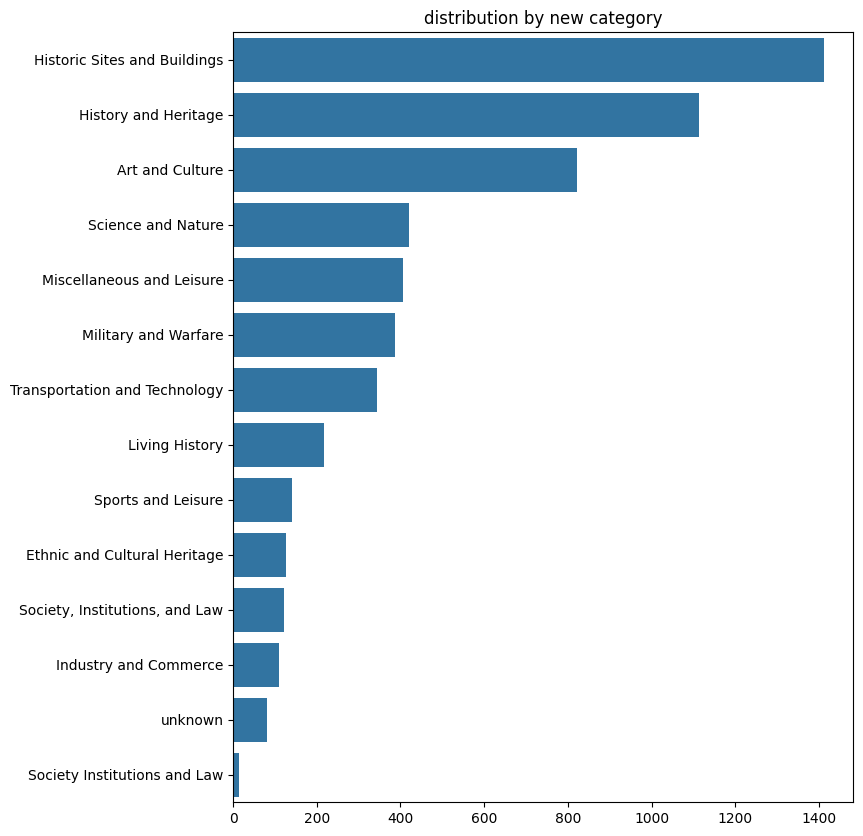

In [111]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,10))
plt.title('distribution by new category')
sns.barplot(x=[i[1] for i in sorted_count],y = [i[0] for i in sorted_count],orient='h')
# plt.xticks(rotation = -90)

## ⚠️ invalid: 1122 recatogrization

In [95]:
import json
import csv

filename = 'data_1101/cats1122.csv'
old2new = {}
with open(filename,'rt') as f:
    reader = csv.reader(f)
    for idx,item in enumerate(reader):
        if idx ==0 :
            pass
        else:
            old2new[item[1]] = item[0]

In [96]:
filename = 'data_1101/museum_category.jsonl'
oldcats = []
with open(filename,'rt') as f:
    for line in f:
        oldcats.append(json.loads(line)['category'])
    

In [97]:
from sentence_transformers import CrossEncoder
catnomt = [cat for cat in oldcats if (cat not in old2new)and(cat!='unknown')]


In [98]:
with open('check2.txt','wt') as f:
    for value in list(set(old2new.values())):
        f.write(value+'\n')


In [99]:
import csv

# read manul mapping list
with open('data_1101/map2.csv','rt') as f:
    reader = csv.reader(f)
    for lin in reader:
        map2 = [line[0].strip() for line in reader]

oldcats = list(set(catnomt))
oldcats.pop(0)

for old,new in zip(oldcats,map2):
    if old in old2new:
        print(old)
        raise ValueError(f'{old} already exists')
    else:
        old2new[old] = new

In [100]:
newdt = []
with open(filename,'rt') as f:
    for line in f:
        data = json.loads(line)
        if data['category'] in ['unknown','']:
            data['new_category'] = 'unknown'
        else:
            data['new_category'] = old2new[data['category']]
            
        newdt.append(data)


In [101]:
cats = [line['new_category'] for line in newdt]
Counter(cats)

Counter({'Historic Sites and Buildings': 1411,
         'History and Heritage': 1113,
         'Art and Culture': 822,
         'Science and Nature': 421,
         'Miscellaneous and Leisure': 407,
         'Military and Warfare': 388,
         'Transportation and Technology': 344,
         'Living History': 217,
         'Sports and Leisure': 140,
         'Ethnic and Cultural Heritage': 126,
         'Society, Institutions, and Law': 122,
         'Industry and Commerce': 109,
         'unknown': 81,
         'Society Institutions and Law': 15})

In [102]:
with open (filename,'wt') as f:
    for line in newdt:
        f.write(json.dumps(line)+'\n')